# Lab Assignment 3

**Submission deadline:**
* **Regular problems: last lab session before or on Monday, 04.12.20**
* **Bonus problems: deadline for Lab Assignment 4**

**Points: 10 + 7 bonus points**


In [ ]:
# Please note that this code needs only to be run in a fresh runtime.
# However, it can be rerun afterwards too.
!pip install -q gdown httpimport

In [1]:
# Standard IPython notebook imports
%matplotlib inline

import os
from io import StringIO

import graphviz
import httpimport
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sstats
import seaborn as sns
import sklearn.ensemble
import sklearn.tree
from tqdm import tqdm_notebook
from tqdm import trange

# In this way we can import functions straight from github
with httpimport.github_repo(
    "janchorowski", "nn_assignments", module="common", branch="nn18"
):
    from common.plotting import plot_mat

sns.set_style("whitegrid")



In [2]:
# @title Data Loading
# We will load a few commonly used datasets:
# - mushroom
# - iris
# - adult
# - congressional voting
# - german credit


# 1. Mushroom dataset
# https://archive.ics.uci.edu/ml/datasets/mushroom
# only categorical attributes with missing values
columns = [
    "target",
    "cap-shape",
    "cap-surface",
    "cap-color",
    "bruises?",
    "odor",
    "gill-attachment",
    "gill-spacing",
    "gill-size",
    "gill-color",
    "stalk-shape",
    "stalk-root",
    "stalk-surface-above-ring",
    "stalk-surface-below-ring",
    "stalk-color-above-ring",
    "stalk-color-below-ring",
    "veil-type",
    "veil-color",
    "ring-number",
    "ring-type",
    "spore-print-color",
    "population",
    "habitat",
]

# Use read_csv to load the data.
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"
mushroom_df = pd.read_csv(url, header=None, names=columns)
mushroom_idx_df = mushroom_df.reset_index()

# 2. Iris
iris_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
iris_df = pd.read_csv(
    iris_url,
    header=None,
    names=["sepal_length", "sepal_width", "petal_length", "petal_width", "target"],
)

# 3. Congressoinal Voting
# Binary attributes, binary class, missing data
vote_df = (
    pd.read_csv(
        "https://pkgstore.datahub.io/machine-learning/vote/vote_csv/data/65f1736301dee4a2ad032abfe2a61acb/vote_csv.csv"
    )
    .rename({"Class": "target"}, axis=1)
    .fillna("na")
)

# 4. Adult
# census records, continuous and categorical attributes (some ordered), missing values
adult_names = [
    "Age",
    "Workclass",
    "fnlwgt",
    "Education",
    "Education-Num",
    "Martial Status",
    "Occupation",
    "Relationship",
    "Race",
    "Sex",
    "Capital Gain",
    "Capital Loss",
    "Hours per week",
    "Country",
    "target",
]
adult_df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=adult_names,
    header=None,
    na_values="?",
)
adult_test_df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",
    names=adult_names,
    header=None,
    na_values="?",
    skiprows=1,
)

# 5. German Credit

german_df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data",
    names=[f"A{d}" for d in range(1, 21)] + ["target"],
    header=None,
    sep=" ",
)

# Problem 1 [2p] 

Download a categorical dataset, such as the [mushroom](https://archive.ics.uci.edu/ml/datasets/mushroom) from UCI and try to find the most predictive variables: 

### Implement mutual information [1p]

Implement the function `entropy` to compute the entropy of a columnt of the dataset.

The [entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)) of a discrete variable is defined to be:

$$H(X) = -\sum_x p_X(x) \log_2 p_X(x).$$

A good in tutorial is given by Chris Olah: https://colah.github.io/posts/2015-09-Visual-Information/.


When $X$ is a discrete random variables, we can estimate the probabilities with counts:

$$p_X(x) = \frac{\text{number of instances where }X=x}{\text{total number of instances}}.$$


Hint: the following `pandas` functions may be useful:
- `count`
- `value_count`

Then use the datafranme's `apply` function to compute the entropy of all columns.

In [13]:
def entropy(series):
    probs = series.value_counts()/series.count()
    H = -np.sum(probs * np.log2(probs + 1e-100))
    return H 

entropy_df = mushroom_df.apply(lambda x: entropy(x))
entropy_df

ID                          12.987975
target                       0.999068
cap-shape                    1.652889
cap-surface                  1.575486
cap-color                    2.510143
bruises?                     0.979327
odor                         2.319414
gill-attachment              0.173129
gill-spacing                 0.637878
gill-size                    0.892256
gill-color                   3.030433
stalk-shape                  0.986927
stalk-root                   1.822922
stalk-surface-above-ring     1.221348
stalk-surface-below-ring     1.399135
stalk-color-above-ring       1.936809
stalk-color-below-ring       1.978163
veil-type                   -0.000000
veil-color                   0.196238
ring-number                  0.420680
ring-type                    1.535121
spore-print-color            2.203227
population                   2.003398
habitat                      2.274747
dtype: float64

Implement the conditional entropy computation

$$H(Y|X) = \sum_x p_X(x) H(Y|x) = \sum_x p_X(x) \sum_y p_Y(y|x) \log_2 p_Y(y|x)$$

Hint 1: the above formula can be computed as follows:
1. split the data by the values of $X$
2. for each value $x$ that $X$ takes, compute the entropy of $Y$
3. average the entropies, weighting them by how frequent the $x$ value ocurred.

Hint 2: helpful pandas constructs are:
- `groupby` and `agg`
- you can aggregate a grouping using your own custom functions


In [4]:
# get a glimpse of what it looks like
mushroom_df.head()

,target,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [7]:
def cond_entropy(df, Y, X):
    """Compute the conditional H(Y|X) in dataframe df
    Args:
        df: a dataframe
        X: the name of the conditioning column
        Y: the name of the column whose entropy we wish to compute
    """
    vals = df[X].unique()
    ys = []
    for val in vals:
        ent = entropy(df[Y][df[X] == val])
        ys.append(ent)
    ys = np.array(ys)
    # weights sum up to one (they have to, they are 'probabilities')
    weights = df.groupby(X).count()[Y]/len(df)
    cond_H = (ys * weights).sum()
    # = np.sum(ys.mean())
    return cond_H

# Now for each column C compute the conditional entropy H(target|C)
# Which variable tells us the most about the target?
cond_entropies = {}
for col in mushroom_df.columns[1:]:
    cond_entropies[col] = cond_entropy(mushroom_df, 'target', col)
    print(f"The entropy of the target conditioned on {col} is:", cond_entropies[col])
    print(f"The entropy of the target conditioned on {col} is:", cond_entropies[col])
print(f"Therefore, {min(cond_entropies, key=cond_entropies.get)} tells us the most about the target")
    
# If Y and X are related, the conditional entropy H(Y|X) will be lower than 
# the entropy H(Y), because intuitivelly, knowing X tells us something about Y, 
# and hence, the randomness (entropy) must decrease.
# So, the variable which yields the smallest H(target|variable) is the one which tells most
# about the target

The entropy of the target conditioned on cap-shape is: 0.16095775558193703
The entropy of the target conditioned on cap-surface is: 0.5708705188548509
The entropy of the target conditioned on cap-color is: 0.8165492985183519
The entropy of the target conditioned on bruises? is: 0.7731254053131438
The entropy of the target conditioned on odor is: 0.01054341490798873
The entropy of the target conditioned on gill-attachment is: 0.436937273779176
The entropy of the target conditioned on gill-spacing is: 0.8981847128758901
The entropy of the target conditioned on gill-size is: 0.6279827865677687
The entropy of the target conditioned on gill-color is: 0.584417223189906
The entropy of the target conditioned on stalk-shape is: 0.9915511243027961
The entropy of the target conditioned on stalk-root is: 0.5112192551969219
The entropy of the target conditioned on stalk-surface-above-ring is: 0.5145032103102141
The entropy of the target conditioned on stalk-surface-below-ring is: 0.812492690708964


### Implement infogain ratio [1p]
Add an ID column, that assigns a unique ID to each observation (row). Compute the mutual information between target and ID. How to interpret the results? Do you think the ID is important in predicting the target? Devise a measure similar to Information Gain Ratio from C4.5 and show its variable ranking.



In [10]:
mushroom_df.insert(0, 'ID', range(len(mushroom_df)))
#mushroom_df.drop(['ID'], axis = 1, inplace=True)

In [11]:
# I(X;Y) == H(Y) - H(Y|X) == I(Y,X)

def mutual_info(df, target, feature):
    return entropy(df[target]) - cond_entropy(df, target, feature)

info = mutual_info(mushroom_df, "target", "ID")
if info == entropy(mushroom_df['target']):
    print(info)

0.9990678968724603


So we get that the **conditional entropy** of target given ID, H(target | ID) = 0, so target is **fully specified** by ID and the mutual information is equal to the entropy of the target column.
This makes sense - if we know the ID, we automatically know whether te shroom is poisonous or not
ID is not important in predicting the result - this is not a feature of a real mushroom,
it's something we introduce to e.g. arrange the data nicely in a table

In [20]:
# drop the ID column first
mushroom_df.drop(['ID'], axis = 1, inplace=True)

In [9]:
def IGR(df, target, feature):
    return mutual_info(df, target, feature) / entropy(df[feature])

IGR_ranking = {}
for col in mushroom_df.columns[1:]:
    IGR_ranking[col] = IGR(mushroom_df, "target", col)

# sort the values from the dictionary:
{k: v for k, v in sorted(IGR_ranking.items(), key=lambda item: item[1])}

C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


{'stalk-shape': 0.007616338689020934,
 'cap-color': 0.0727124398285199,
 'population': 0.108475273943689,
 'habitat': 0.10895780420892451,
 'stalk-surface-below-ring': 0.13335043804314717,
 'gill-color': 0.13682885897355665,
 'gill-spacing': 0.15815426132075966,
 'bruises?': 0.23071191980365693,
 'stalk-root': 0.26761909730297395,
 'cap-surface': 0.2717874162289615,
 'spore-print-color': 0.3822314660418669,
 'stalk-surface-above-ring': 0.39674582636275413,
 'gill-size': 0.4158952036190076,
 'odor': 0.4261957080557829,
 'stalk-color-below-ring': 0.45992224218489136,
 'stalk-color-above-ring': 0.4758912270184345,
 'ring-type': 0.4839932500708979,
 'cap-shape': 0.5070577555842102,
 'gill-attachment': 3.2468908617865884,
 'veil-type': nan,
 'ring-number': 1.204522003044335,
 'veil-color': 5.030886740903897}

# Problem 2: Decision Tree Implementation

Currently, there are no good implementations of Decision Trees in Python.

Sadly, the machine leading toolkit [sklearn](https://scikit-learn.org/stable/index.html) doesn't handle categorical attributes. Let's use this as an excuse to implement Decision Tress ourselves.



## Decision Tree Task 1: Purity Measures [1p]

Please fill the purity measures below.

Verify the correctness by plotting the purity values if a two-class set with given class probabilities

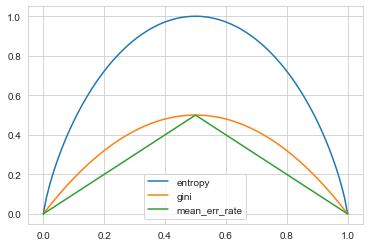

In [3]:
def mean_err_rate(counts):
    """ Counts is a Pandas series"""
    s = counts.sum()
    p = counts / s
    return 1 - p.max()


def gini(counts):
    """ Counts is a Pandas series"""
    s = counts.sum()
    p = counts / s
    return 1 - (p**2).sum()


def entropy(counts):
    """ Counts is a Pandas series"""
    s = counts.sum()
    p = counts / s
    p = p * np.log2(p + 1e-100)
    return -p.sum()

# Make a plot of the purity functions
support = np.linspace(0,1,101)
errs_mean = [mean_err_rate(np.array([x, 1.0-x])) for x in support]
errs_entropy = [entropy(np.array([x, 1.0-x])) for x in support]
errs_gini = [gini(np.array([x, 1.0-x])) for x in support]
plt.figure()
plt.plot(support, errs_entropy, label = "entropy")
plt.plot(support, errs_gini, label = "gini")
plt.plot(support, errs_mean, label = "mean_err_rate")
plt.legend()
plt.show()

## Decision Tree Task 2: Categorical Splits [1p]

### The anatomy of a Decision Tree


All internal (non-leaf) nodes of a split training examples according to a test implemented by the node. We capture this behavior using a generic `AbstractSplit` class which implements a split of data contained in the dataframe `df` using the attribute `attr`.

The class features a lightweight constructor, `__init__` which only saves the information required to later split a training dataframe and recursively build the subtrees using the `build_subtrees` method.

Fill in the blanks in the code below, as indicated by the TODO comments.

In [4]:
class AbstractSplit:
    """Split the examples in a tree node according to a criterion.
    """

    def __init__(self, attr):
        self.attr = attr

    def __call__(self, x):
        """Return the subtree corresponding to x."""
        raise NotImplementedError

    def build_subtrees(self, df, subtree_kwargs):
        """Recuisively build the subtrees."""
        raise NotImplementedError

    def iter_subtrees(self):
        """Return an iterator over subtrees."""
        raise NotImplementedError

    def add_to_graphviz(self, dot):
        """Add the split to the graphviz vizalization."""
        raise NotImplementedError

    def __str__(self):
        return f"{self.__class__.__name__}: {self.attr}"

We will first implement a Multivariate Categorical split which has a 
subtree for each value that an attribute may take.

In [47]:
np.random.choice(mushroom_df.columns)

'odor'

In [5]:
class CategoricalMultivalueSplit(AbstractSplit):
    def build_subtrees(self, df, subtree_kwargs):
        self.subtrees = {}
        for group_name, group_df in df.groupby(self.attr):
            child = Tree(group_df, **subtree_kwargs)
            self.subtrees[group_name] = child

    def __call__(self, x):
        # calling the class returns child df stored in the dictionary
        # Return the subtree for a given sample
        if x[self.attr] in self.subtrees:
            return self.subtrees[x[self.attr]]
        # x to był u mnie jeden wiersz w dataframe, czyli pd.Series
        # split wie po jakim jest atrybucie
        # wiec idziemy do odpowiedniego pod-drzewa 

    def iter_subtrees(self):
        return self.subtrees.values()

    def add_to_graphviz(self, dot, parent, print_info):
        for split_name, child in self.subtrees.items():
            child.add_to_graphviz(dot, print_info)
            dot.edge(f"{id(parent)}", f"{id(child)}", label=f"{split_name}")

In [6]:
def get_categorical_split_and_purity(
    df, parent_purity, purity_fun, attr, normalize_by_split_entropy=False
):
    """Return a multivariate split and its purity.
    Args:
        df: a dataframe
        parent_purity: purity of the parent node
        purity_fun: function to compute the purity
        attr: attribute over which to split the dataframe
        normalize_by_split_entropy: if True, divide the purity gain by the split
            entropy (to compute https://en.wikipedia.org/wiki/Information_gain_ratio)
    
    Returns:
        pair of (split, purity_gain)
    """
    # Initialize
    split = CategoricalMultivalueSplit(attr)
    # Compute the purity after the split
    mean_purities = []
    for _, group_df in df.groupby(attr):
            # the term in bracket is 'weight' of each group
            # similarly as we had in the case of conditional probabilities
            purity = purity_fun(group_df["target"].value_counts()) * (len(group_df) / len(df))
            mean_purities.append(purity)
    mean_child_purity = np.sum(mean_purities)
    # Note: when purity is measured by entropy, this corresponds to Mutual Information
    purity_gain = parent_purity - mean_child_purity
    if normalize_by_split_entropy:
        purity_gain /= entropy(df[attr].value_counts())
    return split, purity_gain

In [7]:
def get_split(df, criterion="infogain", nattrs=None):
    """Finds best split on the given dataframe.
    
    Attributes:
        - df: the dataframe of samples in the node to be split
        - criterion: split selection criterion
        - nattrs: flag to randomly limit the number of considered attributes. Used 
          in random tree impementations.

    Returns:
        - If no split exists, return None.
        - If a split exists, return an instance of a subclass of AbstractSplit
    """
    # Implement termination criteria:
    # TermCrit1: Node is purel
    target_value_counts = df["target"].value_counts()
    if len(target_value_counts) == 1:
        return None
    # Random Forest support
    # restrict possible_splits to a few randomly selected attributes
    if nattrs is not None:
        choices = []
        while len(choices) < nattrs:
            new_choice = np.random.choice(df.columns)
            if new_choice not in choices and new_choice != "target" and df[new_choice].nunique() > 1:
                choices.append(new_choice)
        possible_splits = choices
    else:
        possible_splits = [feat for feat in df.columns if feat != "target" if df[feat].nunique() > 1]
    # TermCrit2: No split is possible
    #    First get a list of attributes that can be split
    #    (i.e. attribute is not target and atribute can take more than one value)
    #
    #    The list of attributes on which we can split will also be handy for building random trees.
    # NOTE: possible_splits must be a LIST
    
    assert "target" not in possible_splits
    #    Terminate early if none are possible
    # not [] == True
    if not possible_splits:
        return None

    # Get the base purity measure and the purity function
    if criterion in ["infogain", "infogain_ratio"]:
        purity_fun = entropy
    elif criterion in ["mean_err_rate"]:
        purity_fun = mean_err_rate
    elif criterion in ["gini"]:
        purity_fun = gini
    else:
        raise Exception("Unknown criterion: " + criterion)
    base_purity = purity_fun(target_value_counts)

    best_purity_gain = -1
    best_split = None
    
    for attr in possible_splits:
        if np.issubdtype(df[attr].dtype, np.number):
            # Handling of numerical attributes will be defined later, in a manner
            # similar to categorical ones
            split_sel_fun = get_numrical_split_and_purity
        else:
            split_sel_fun = get_categorical_split_and_purity

        split, purity_gain = split_sel_fun(
            df,
            base_purity,
            purity_fun,
            attr,
            normalize_by_split_entropy=criterion.endswith("ratio"),
        )

        if purity_gain > best_purity_gain:
            best_purity_gain = purity_gain
            best_split = split
    return best_split

We can now define a Tree class, which represents both a Decision Tree and its Nodes.

Each node saves its class distribution in the `counts` attribute and debug/visualization information in the `info` field. 

Leaf nodes have `split == None`, while internal nodes have a split which points to subtrees.


In [8]:
class Tree:
    def __init__(self, df, **kwargs):
        super().__init__()
        # Assert that there are no missing values,
        # TODO: remove this for bonus problem #2.4
        assert not df.isnull().values.any()

        # Technicality:
        # We need to let subtrees know about all targets to properly color nodes
        # We pass this in subtree arguments.
        if "all_targets" not in kwargs:
            kwargs["all_targets"] = sorted(df["target"].unique())
        # Save keyword arguments to build subtrees
        kwargs_orig = dict(kwargs)
        # Get kwargs we know about, remaning ones will be used for splitting
        self.all_targets = kwargs.pop("all_targets")

        # Save debug info for visualization
        # Debugging tip: contents of self.info are printed in tree visualizations!
        self.counts = df["target"].value_counts()
        self.info = {
            "num_samples": len(df),
            "entropy": entropy(self.counts),
            "gini": gini(self.counts),
        }

        self.split = get_split(df, **kwargs)
        # split outputs either None (False) or a pair of values (True)
        if self.split:
            self.split.build_subtrees(df, kwargs_orig)

    def get_target_distribution(self, sample):
        # sample is a datasample, ie. a row from dataframe
        # TODO: descend into subtrees and return the leaf target distribution
        if self.split is None:
            return self.counts
        else:
            subtree = self.split(sample)
            while subtree:
                # nice recursion
                return subtree.get_target_distribution(sample)

            
    def classify(self, sample):
        voting = self.get_target_distribution(sample)
        if voting is None:
            return np.random.choice(self.all_targets)
        # sample is a datasample, ie. a row from dataframe
        # TODO: classify the sample by descending into the appropriate subtrees.
        # Hint: you can also use self.get_target_distribution
        else:
            return voting.idxmax()
        
    def draw(self, print_info=True):
        dot = graphviz.Digraph()
        self.add_to_graphviz(dot, print_info)
        return dot

    def add_to_graphviz(self, dot, print_info):
        freqs = self.counts / self.counts.sum()
        freqs = dict(freqs)
        colors = []
        freqs_info = []
        for i, c in enumerate(self.all_targets):
            freq = freqs.get(c, 0.0)
            if freq > 0:
                colors.append(f"{i%9 + 1};{freq}")
                freqs_info.append(f"{c}:{freq:.2f}")
        colors = ":".join(colors)
        labels = [" ".join(freqs_info)]
        if print_info:
            for k, v in self.info.items():
                labels.append(f"{k} = {v}")
        if self.split:
            labels.append(f"split by: {self.split.attr}")
        dot.node(
            f"{id(self)}",
            label="\n".join(labels),
            shape="box",
            style="striped",
            fillcolor=colors,
            colorscheme="set19",
        )
        if self.split:
            self.split.add_to_graphviz(dot, self, print_info)

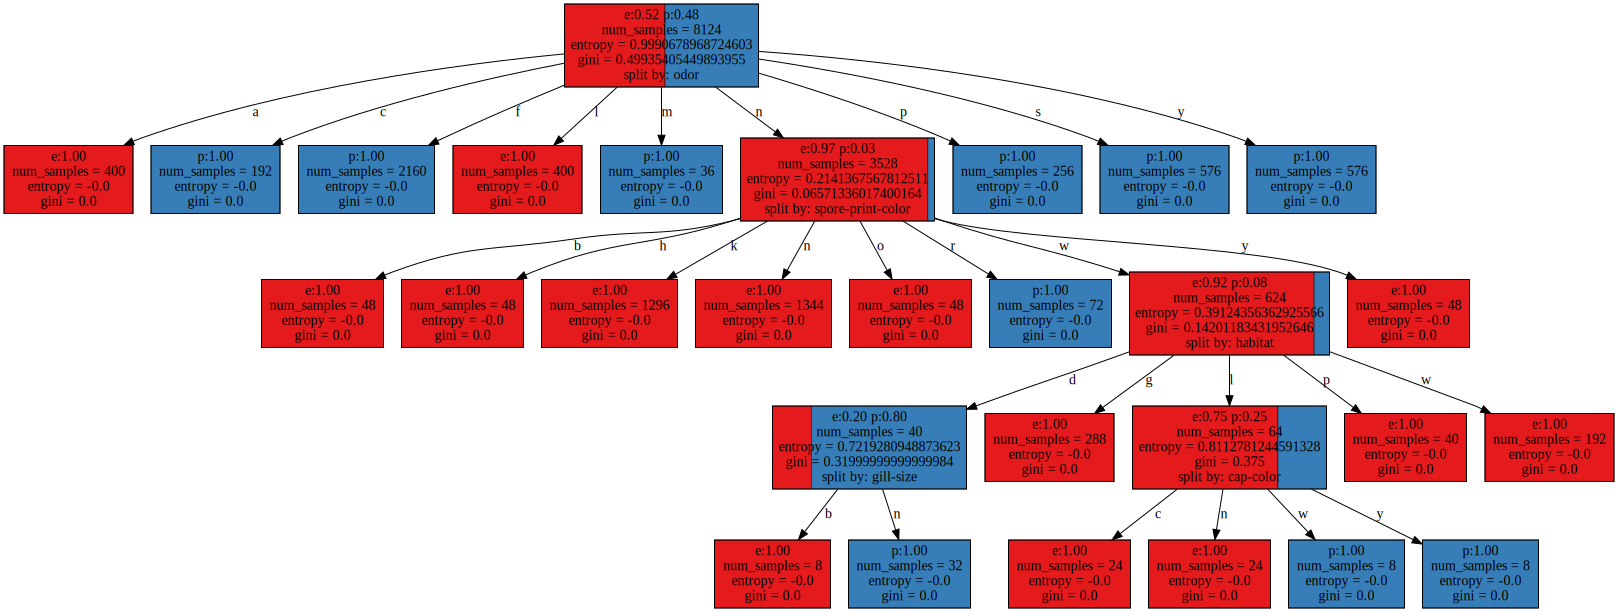

In [9]:
# Train a Decision Tree on the mushroom data.
# Plot the tree using the `.draw()` method.
# Note: for this code to work you must fix the todos in the previous sections

mushroom_tree = Tree(mushroom_df)
mushroom_tree.draw()

**Answer the questions below**
1. How many samples are classified correctly by a tree with only one split?


In [10]:
len(mushroom_df) -  3528

4596

In [11]:
mushroom_df.apply(lambda x: mushroom_tree.classify(x), axis = 1)

0       p
1       e
2       e
3       p
4       e
       ..
8119    e
8120    e
8121    e
8122    p
8123    e
Length: 8124, dtype: object

2. Is the tree different when different purity functions are used?

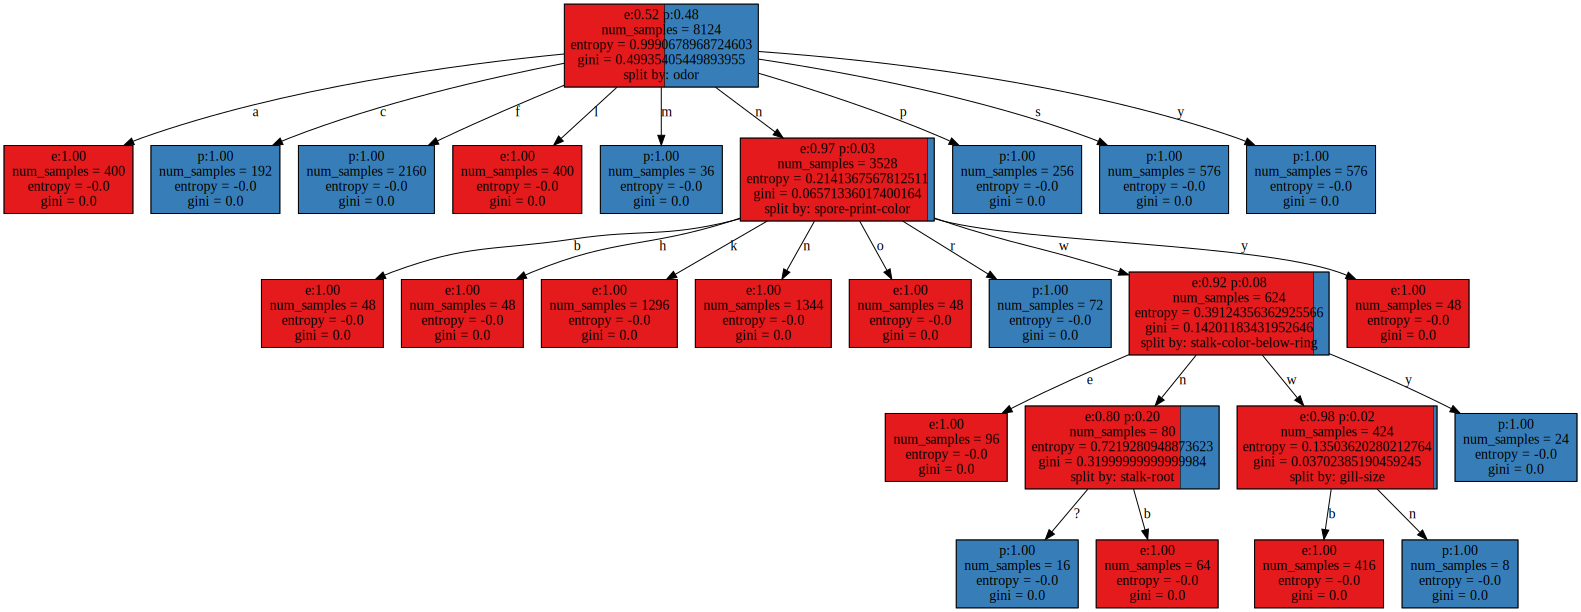

In [12]:
mushroom_tree_MER = Tree(mushroom_df, criterion = "mean_err_rate")
mushroom_tree_MER.draw()
# clearly different than with other criteria

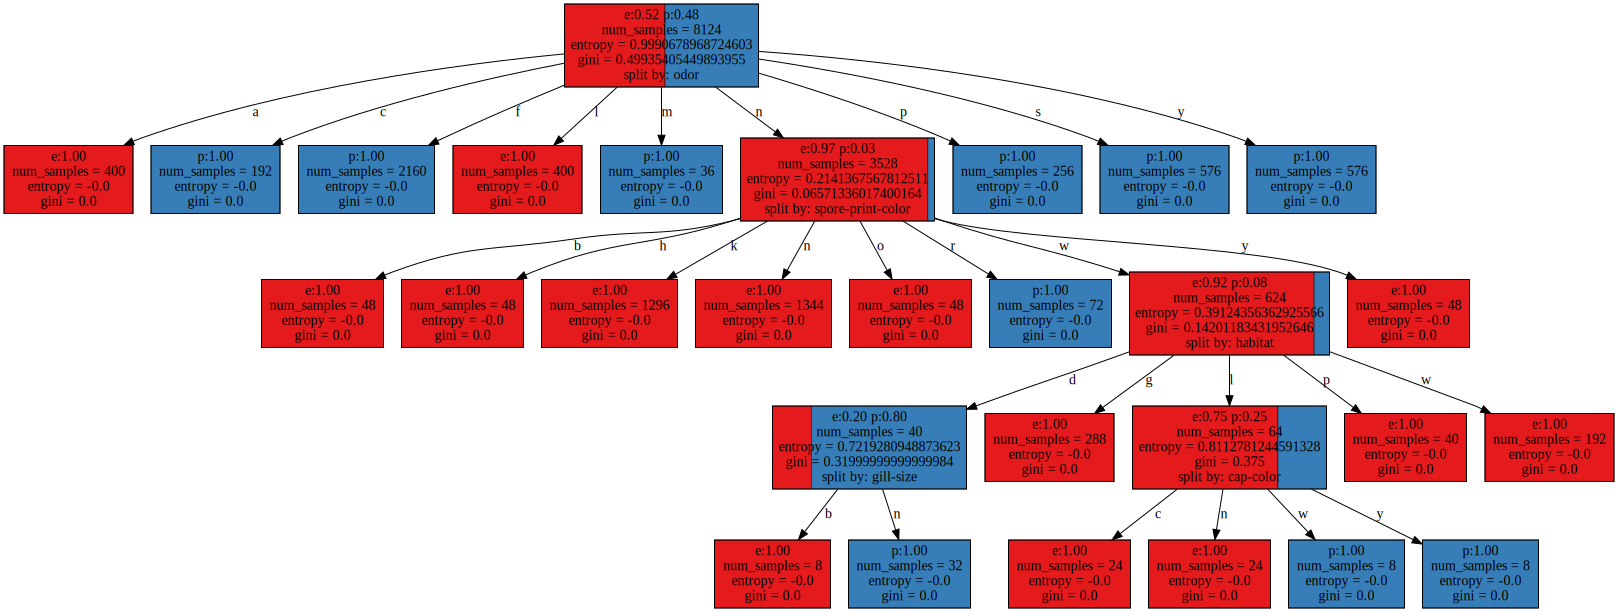

In [13]:
mushroom_tree_gini = Tree(mushroom_df, criterion ="gini")
mushroom_tree_gini.draw()
# clearly different than with other criteria

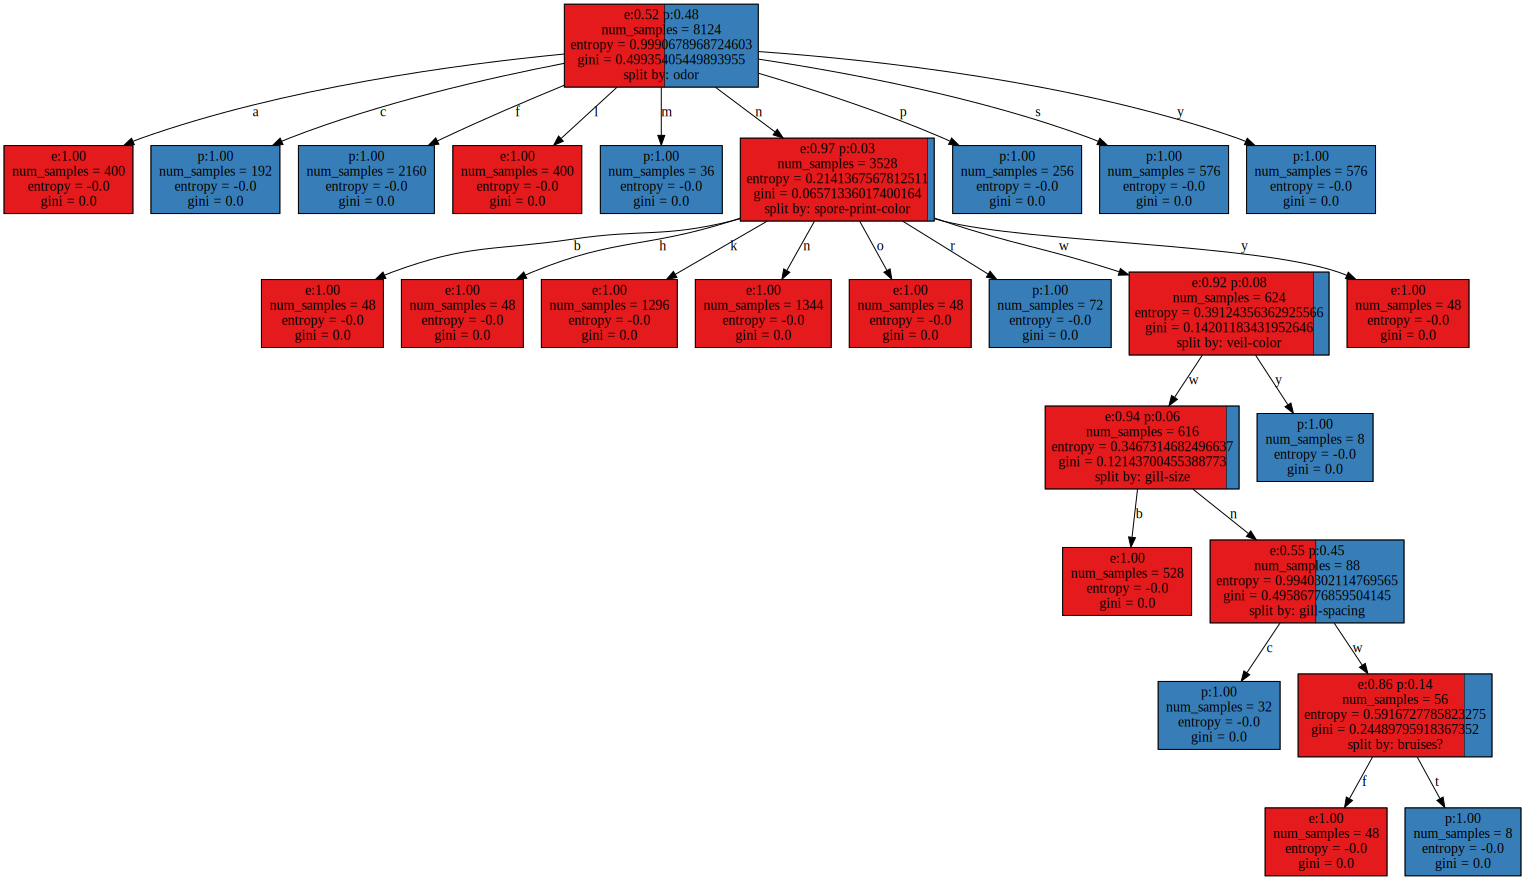

In [14]:
mushroom_tree_gini = Tree(mushroom_df, criterion ="infogain_ratio")
mushroom_tree_gini.draw()
# clearly different than with other criteria

## Decision Tree Task 3: Numerical Splits [1p]
A numerical split requires to search for the best threshold. Implement the selection of splits for numerical attributes below.

In [15]:
class NumericalSplit(AbstractSplit):
    def __init__(self, attr, th):
        super(NumericalSplit, self).__init__(attr)
        self.th = th

    def build_subtrees(self, df, subtree_kwargs):
        self.subtrees = (
            Tree(df[df[self.attr] <= self.th], **subtree_kwargs), # left
            Tree(df[df[self.attr] > self.th], **subtree_kwargs), # right
        )

    def __call__(self, x):
        # return the subtree for the data sample `x`
        # left tree is always ' <= threshold '
        if x[self.attr] <= self.th:
            return self.subtrees[0]
        # right tree is always ' > threshold'
        else:
            return self.subtrees[1]


    def __str__(self):
        return f"NumericalSplit: {self.attr} <= {self.th}"

    def iter_subtrees(self):
        return self.subtrees

    def add_to_graphviz(self, dot, parent, print_info):
        self.subtrees[0].add_to_graphviz(dot, print_info)
        dot.edge(f"{id(parent)}", f"{id(self.subtrees[0])}", label=f"<= {self.th:.2f}")
        self.subtrees[1].add_to_graphviz(dot, print_info)
        dot.edge(f"{id(parent)}", f"{id(self.subtrees[1])}", label=f"> {self.th:.2f}")


def get_numrical_split_and_purity(
    df, parent_purity, purity_fun, attr, normalize_by_split_entropy=False
):
    """Find best split thereshold and compute the average purity after a split.
    Args:
        df: a dataframe
        parent_purity: purity of the parent node
        purity_fun: function to compute the purity
        attr: attribute over whihc to split the dataframe
        normalize_by_split_entropy: if True, divide the purity gain by the split
            entropy (to compute https://en.wikipedia.org/wiki/Information_gain_ratio)
    
    Returns:
        pair of (split, purity_gain)
    """
    attr_df = df[[attr, "target"]].sort_values(attr)
    targets = attr_df["target"]
    values = attr_df[attr]
    # Start with a split that puts all the samples into the right subtree
    # while moving the threshold:
    # right_counts = dataframe([e] ------ 666
    #                          [p] ------ 555)
    # left_counts =  dataframe([e] ------ 000
    #                          [p] ------ 000)
    # if value above threshold, e.g:
    # right_counts[target = e] -= 1  ==> dataframe([e] ------ 665
    #                                              [p] ------ 555)
    # left_counts[target = e]   +=1  ==> dataframe([e] ------ 001
    #                                              [p] ------ 000) etc.
    right_counts = targets.value_counts()
    left_counts = right_counts * 0

    best_split = None  # Will be None, or NumericalSplit(attr, best_threshold)
    best_purity_gain = -1
    N = len(attr_df)
    for row_i in range(N - 1):
        # Update the counts of targets in the left and right subtree and compute
        # the purity of the slipt for all possible thresholds!
        # Return the best split found.
        
        row_target = targets.iloc[row_i]
        attribute_value = values.iloc[row_i]
        next_attribute_value = values.iloc[row_i + 1]
        split_threshold = (attribute_value + next_attribute_value) / 2.0
        
        # TODO: update left_counts and right_counts
        # the target in row_i gets moved to left tree if it is 
        right_counts[row_target] -= 1
        left_counts[row_target] += 1
        
        # The split is possible if attribute_value != next_attribute_value
        if attribute_value == next_attribute_value:
            continue
        # Remember that the attribute may have duplicate values and all samples
        # with the same attribute value must end in the same subtree!
        else:
            # sprawdzamy zmiane dopiero po tym jak przerzucimy element z jednego do drugiego.
            # Jesli wartosc sie powtarza to po prostu przerzucamy WSZYSTKIE - i tak podejmiemy
            # jedna taka sama decyzje dla wszystkich
            
            # use the function defined in the lecture notes as a reference
            left_purity = left_counts.sum() * purity_fun(left_counts) 
            right_purity = right_counts.sum() * purity_fun(right_counts)
            mean_child_purity = (left_purity + right_purity) / N
            purity_gain = parent_purity - mean_child_purity
            # Consider the split at threshold, i.e. NumericalSplit(attr, split_threshold)
            # and save it if it the best one. The loop should return the best possible split.
            if purity_gain > best_purity_gain:
                best_purity_gain = purity_gain
                best_split = NumericalSplit(attr, split_threshold)

    return best_split, best_purity_gain

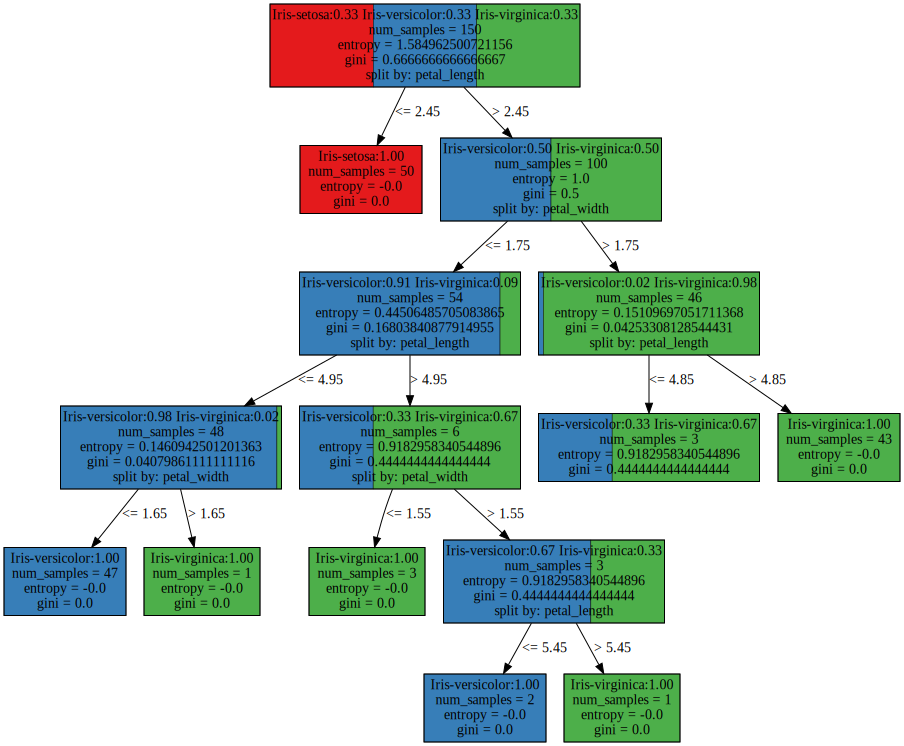

In [16]:
# TODO: apply the tree to Iris with petal_length and petal_width attributes
iris2d = iris_df[["petal_length", "petal_width", "target"]]

iris_tree = Tree(iris2d, criterion="infogain")
iris_tree.draw()


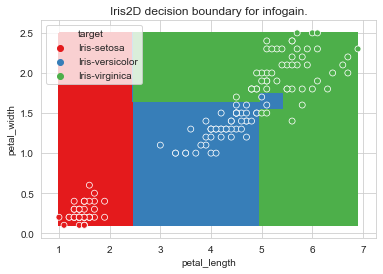

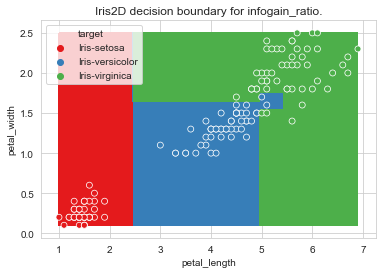

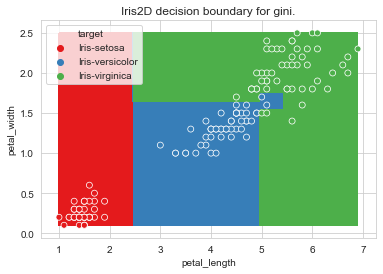

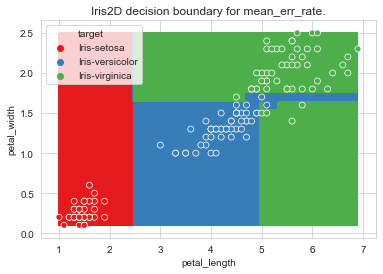

In [17]:
# TODO: to verify the tree building algorithm draw Iris2D decision boundary
# for different splitting criteria.
mesh_x, mesh_y = np.meshgrid(
    np.linspace(iris2d.petal_length.min(), iris2d.petal_length.max(), 100),
    np.linspace(iris2d.petal_width.min(), iris2d.petal_width.max(), 100),
)

mesh_data = np.hstack([mesh_x.reshape(-1, 1), mesh_y.reshape(-1, 1)])
mesh_data = pd.DataFrame(mesh_data, columns=iris2d.columns[:-1])

preds = np.empty((len(mesh_data),))

for criterion in ["infogain", "infogain_ratio", "gini", "mean_err_rate"]:
    iris2d_tree = Tree(iris2d, criterion=criterion)
    for i, (_, r) in enumerate(mesh_data.iterrows()):
        preds[i] = iris2d_tree.all_targets.index(iris2d_tree.classify(r))

    plt.figure()
    plt.title(f"Iris2D decision boundary for {criterion}.")
    plt.contourf(
        mesh_x, mesh_y, preds.reshape(mesh_x.shape), cmap="Set1", vmin=0, vmax=7
    )
    sns.scatterplot(
        x="petal_length", y="petal_width", hue="target", data=iris_df, palette="Set1",
    )

## Decision Tree Task 4: Handling missing data [2bp]

Implement support for missing values. A possible strategy does the following:
each time (both during training and testing) we encounter a split for which the sample misses attribute's value, we a weighted copy of the sample down each subtree, with the weight equal to the probaiblity that the child subtree is selected (i.e. proportional to number of samples put into the subtree.).

## Decision Tree Task 5: Pruning [2-4bp]

Tree pruning tries to remove splits that don't result in a decrease of the error rate.

There are two possible strategies:

### 1. Reduced Error Rate Pruning
Build a tree using all the data. Then split the training set into 10 crossvalidation subsets. Then in a loop over the tesintg crossvalidation subset:
- put the data from the remaining 9 subsets through the tree, remember distributions at each node (leaf and internal nodes)
- classify the samples in the testing subset, record the error rate for all nodes 
- remove leaf nodes that have a higher error rate than their parents.

### 2. Confidence-interval Pruning
Build the deicision tree and record the class distribution in each node. For each node, estimate the upper confidence interval on the error rate. Remove nodes that have a higher upper bound on the error rate than their parents.

As you can see, the two strategies are quite similar: both estimate the error rate for all nodes in the tree and remove subtrees that do not improve it. The difference stems from the way in which the error rates are computed.

### Task: 

Split the voting dataset into a training and testing set using a 70%-30% ratio.

Train a decision tree and prune it using either method 1. or 2.

Compare the error rates on the test set of the original and pruned tree.

**Implementation hint**: you can store the information related to pruning in the `Tree.info` field. In this way, it will be printed by `Tree.draw` method.

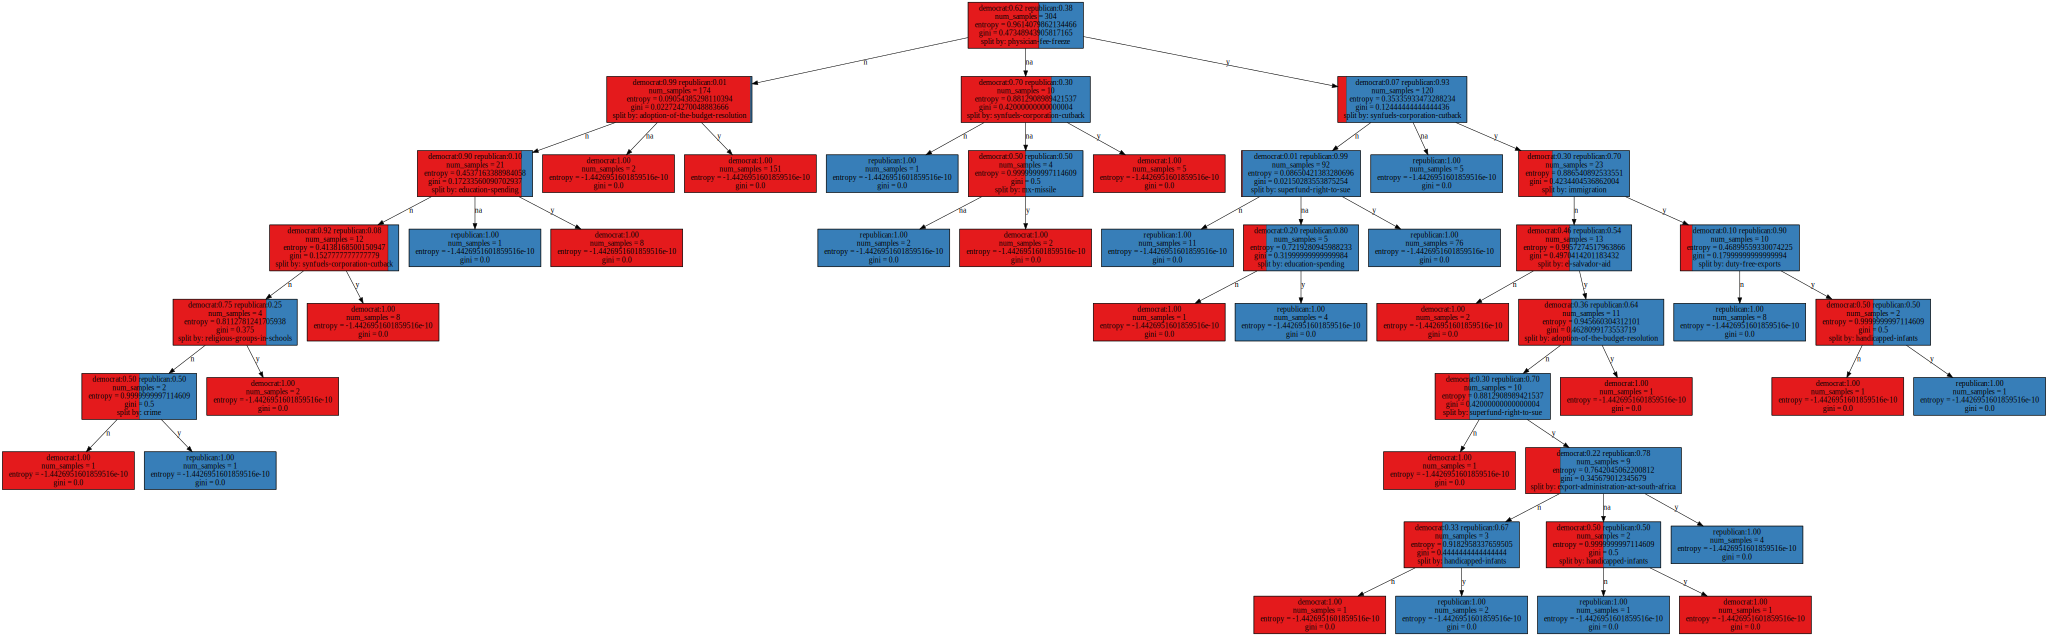

In [ ]:
vote_train_df, vote_test_df = sklearn.model_selection.train_test_split(
    vote_df, test_size=0.3
TODO

# TODO: Build and draw the tree


Unpruned err rate: 0.05343511450381677
Pruned err rate: 0.04580152671755722


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


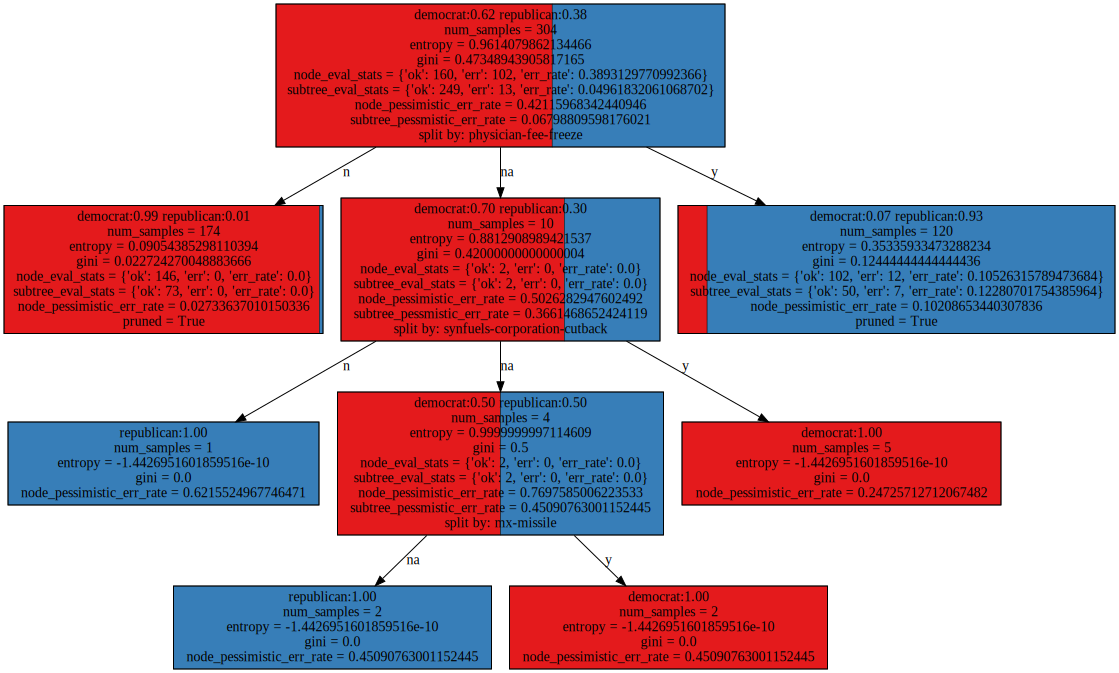

In [ ]:
# TODO: implement a pruning method of your choice



# Problem 4: Random Forest [3p]

We will use the german credit dataset. Please split it into a training and testing set using a 70%-30% ratio.

Next train and test a regular decision tree on it.

Then:
1. Implement randomized tree bulding, by restricting the set of attrbutes considered for data spltting in the tree building code below (the `nattrs` argument). Alternatively, you can use trees from sklearn (se below).
2. Build a forest of at least 20 Random Trees, each selecting splits out of 1-3 attributes on the German Credit data. After adding each random tree:
    - Compute the tree's test error rate and its OOB error rate
    - Record the accurracy of the RF after adding the tree to it. 
    
    At the end ot training record the forest's OOB error rate.

What is the mean accurracy of individual trees in the forest? What is the final forest accurracy? 

Define the agreement between two trees to be the fraction of test samples on which the answer of the two trees is identical. What is the mean aggreement of trees in the forest? How does it change with the number of attributes considered for each split? What is the impact of training each tree in the forest on a bootstrap sample, rather than on the full train set?

**Note:** This assignment assumes that you use either your own implementation of the decision tree from Problem 3, or the implementation of [trees from sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). Since sklearn's trees don't support categorical attributes, use the numerical variant of the German Credit dataset (cf. last year's AdaBoost demo at https://github.com/janchorowski/ml_uwr/blob/fall2019/lectures/05_adabost_demo.ipynb), or try to encode the categorical variables using the [1-Hot Encoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).

In [18]:
from tqdm.notebook import tqdm as progress
def bootstrap_indices(df):
    N = len(df)
    train_idx = np.random.randint(0, N - 1, size=(N,))
    oob_idx = np.ones((N,), dtype=bool)
    oob_idx[train_idx] = 0
    oob_idx = np.where(oob_idx)[0]
    return train_idx, oob_idx

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,A12,A13,A14,A15,A16,A17,A18,A19,A20,target
0,A14,15,A34,A46,1532,A62,A73,4,A92,A101,...,A123,31,A143,A152,1,A173,1,A191,A201,1
1,A11,24,A32,A40,1442,A61,A74,4,A92,A101,...,A123,23,A143,A151,2,A173,1,A191,A201,2
2,A14,36,A34,A43,9566,A61,A73,2,A92,A101,...,A123,31,A142,A152,2,A173,1,A191,A201,1
3,A11,18,A34,A42,2124,A61,A73,4,A92,A101,...,A121,24,A143,A151,2,A173,1,A191,A201,2
4,A14,36,A32,A40,3079,A65,A73,4,A93,A101,...,A121,36,A143,A152,1,A173,1,A191,A201,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,A11,12,A34,A40,4843,A61,A75,3,A93,A102,...,A122,43,A143,A151,2,A173,1,A192,A201,2
996,A11,9,A32,A43,1366,A61,A72,3,A92,A101,...,A122,22,A143,A151,1,A173,1,A191,A201,2
997,A13,36,A32,A43,5848,A61,A73,4,A93,A101,...,A123,24,A143,A152,1,A173,1,A191,A201,1
998,A11,18,A33,A46,8471,A65,A73,1,A92,A101,...,A123,23,A143,A151,2,A173,1,A192,A201,1


In [102]:
# shuffle data first
german_df = german_df.sample(frac=1).reset_index(drop=True)
# 70:30 train-test split
train_germany = german_df.iloc[0:699]
test_germany = german_df.iloc[700:]

In [110]:
N_trees = 10
# storage for models
random_forest = {}
# global OOB and test counts - used for obtaining global accuracies
oob_vote_counts_global = [
    pd.Series(data=0, index=train_germany['target'].unique()) for _ in range(len(train_germany))
    ]
test_vote_counts_global = [
    pd.Series(data=0, index=train_germany['target'].unique()) for _ in range(len(test_germany))
    ]
# get storages for individual and global OOB and test accuracies
oob_errate = np.zeros(N_trees)
test_errate = np.zeros(N_trees)
oob_errates_global = np.zeros(N_trees)
test_errates_global = np.zeros(N_trees)
accuracies = []
# oob_idx do not cover all indices of train_germany - 
# need to have a list with already encountered indices to compare the global OOB accuracy
idx_compare = np.zeros(len(train_germany), dtype = bool)

for i in progress(range(N_trees)):
    train_idx, oob_idx = bootstrap_indices(train_germany)
    tree = Tree(train_germany.iloc[train_idx], nattrs = 3)
    
    # Compute OOB predictions
    oob_preds = train_germany.iloc[oob_idx].apply(lambda x: tree.classify(x), axis = 1)
    # oob_preds is a pandas Series
    # we can't enumerate because oob_inx are random, not ordered values
    for pred, idx in zip(oob_preds,oob_idx):
        oob_vote_counts_global[idx][pred] += 1
        idx_compare[idx] = True
    # confront with true values - get individual OOB accuracy
    oob_errate[i] = (train_germany['target'].iloc[oob_idx] != oob_preds).mean()

    # Compute test predictions
    test_preds = test_germany.apply(lambda x: tree.classify(x), axis = 1)
    # test_preds is a pandas Series
    # can use enumerate because indices are 'regular'
    for idx, pred in enumerate(test_preds):
        test_vote_counts_global[idx][pred] += 1
    # confront with true values - get individual test accuracy
    test_errate[i] = (test_germany['target'] != test_preds).mean()
    
    #update the list with individual test accuracies    
    # OOB predictions made with all trees currently in the forest
    # note - we may have elements of oob_vote_counts_global which have not had been updated yet
    # and therefore these cannot be considered when comparing with the training data
    # so we consider only non-zero Series from oob_vote_counts_global
    oob_preds_global = np.array([counts.idxmax() for counts in oob_vote_counts_global if counts.sum()])
    
    # test predictions made with all trees currently in the forest
    test_preds_global = np.array([counts.idxmax() for counts in test_vote_counts_global])

    # confront with true values - get global OOB and test accuracy from all already created trees
    oob_errates_global[i] = (oob_preds_global != train_germany['target'].iloc[idx_compare]).mean()
    test_errates_global[i] = (test_preds_global != test_germany['target']).mean()
    
    # add tree model to the dictionary
    random_forest[f"Tree_{i}"] = tree





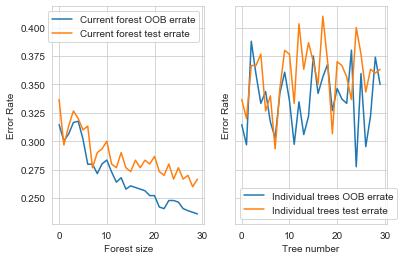

In [116]:
# plot the resuts

fig, ax = plt.subplots(1,2, sharey = True)
ax, ax1 = ax[0], ax[1]
ax.plot(range(N_trees), oob_errates_global, label='Current forest OOB errate')
ax.plot(range(N_trees), test_errates_global, label='Current forest test errate')
ax.legend()
ax.set_xlabel('Forest size')
ax.set_ylabel('Error Rate')

ax1.plot(range(N_trees), oob_errate, label='Individual trees OOB errate')
ax1.plot(range(N_trees), test_errate, label='Individual trees test errate')
ax1.legend()
ax1.set_xlabel('Tree number')
ax1.set_ylabel('Error Rate')
plt.subplots_adjust(hspace=10)
plt.show()

What is the mean accurracy of individual trees in the forest? What is the final forest accurracy?


In [118]:
print(f"Mean test error rate of individual trees: {np.mean(test_errate)*100}")
print(f"Mean OOB error rate of individual trees: {np.mean(oob_errate)*100}")
print(f'Final forest test error rate : {test_errates_global[-1]*100}')
print(f'Final forest OOB error rate : {oob_errates_global[-1]*100}')

Mean error rate of individual trees: 35.86666666666667
Final forest test error rate : 26.666666666666668
Final forest OOB error rate : 23.605150214592275


Define the agreement between two trees to be the fraction of test samples on which the answer of the two trees is identical. What is the mean aggreement of trees in the forest?

In [124]:
comparison=[]
for i in progress(range(N_trees)):
    tree1 = random_forest[f"Tree_{i}"]
    test_preds1 = test_germany.apply(lambda x: tree1.classify(x), axis = 1)
    for j in range (i, N_trees):
        if i != j:
            tree2 = random_forest[f"Tree_{j}"]
            test_preds2 = test_germany.apply(lambda x: tree2.classify(x), axis = 1)
            comparison.append((test_preds1 == test_preds2).mean())
mean_agreement = np.mean(comparison)
mean_agreement

0.6373563218390804

How does it change with the number of attributes considered for each split? What is the impact of training each tree in the forest on a bootstrap sample, rather than on the full train set?

In [ ]:
N_trees = 10
# storage for models
random_forest = {}
# global OOB and test counts - used for obtaining global accuracies
oob_vote_counts_global = [
    pd.Series(data=0, index=train_germany['target'].unique()) for _ in range(len(train_germany))
    ]
test_vote_counts_global = [
    pd.Series(data=0, index=train_germany['target'].unique()) for _ in range(len(test_germany))
    ]
# get storages for individual and global OOB and test accuracies
oob_errate = np.zeros(N_trees)
test_errate = np.zeros(N_trees)
oob_errates_global = np.zeros(N_trees)
test_errates_global = np.zeros(N_trees)
accuracies = []
# oob_idx do not cover all indices of train_germany - 
# need to have a list with already encountered indices to compare the global OOB accuracy
idx_compare = np.zeros(len(train_germany), dtype = bool)

for i in progress(range(N_trees)):
    train_idx, oob_idx = bootstrap_indices(train_germany)
    tree = Tree(train_germany.iloc[train_idx], nattrs = 2)
    
    # Compute OOB predictions
    oob_preds = train_germany.iloc[oob_idx].apply(lambda x: tree.classify(x), axis = 1)
    # oob_preds is a pandas Series
    # we can't enumerate because oob_inx are random, not ordered values
    for pred, idx in zip(oob_preds,oob_idx):
        oob_vote_counts_global[idx][pred] += 1
        idx_compare[idx] = True
    # confront with true values - get individual OOB accuracy
    oob_errate[i] = (train_germany['target'].iloc[oob_idx] != oob_preds).mean()

    # Compute test predictions
    test_preds = test_germany.apply(lambda x: tree.classify(x), axis = 1)
    # test_preds is a pandas Series
    # can use enumerate because indices are 'regular'
    for idx, pred in enumerate(test_preds):
        test_vote_counts_global[idx][pred] += 1
    # confront with true values - get individual test accuracy
    test_errate[i] = (test_germany['target'] != test_preds).mean()
    
    #update the list with individual test accuracies    
    # OOB predictions made with all trees currently in the forest
    # note - we may have elements of oob_vote_counts_global which have not had been updated yet
    # and therefore these cannot be considered when comparing with the training data
    # so we consider only non-zero Series from oob_vote_counts_global
    oob_preds_global = np.array([counts.idxmax() for counts in oob_vote_counts_global if counts.sum()])
    
    # test predictions made with all trees currently in the forest
    test_preds_global = np.array([counts.idxmax() for counts in test_vote_counts_global])

    # confront with true values - get global OOB and test accuracy from all already created trees
    oob_errates_global[i] = (oob_preds_global != train_germany['target'].iloc[idx_compare]).mean()
    test_errates_global[i] = (test_preds_global != test_germany['target']).mean()
    
    # add tree model to the dictionary
    random_forest[f"Tree_{i}"] = tree





In [ ]:
comparison=[]
for i in progress(range(N_trees)):
    tree1 = random_forest[f"Tree_{i}"]
    test_preds1 = test_germany.apply(lambda x: tree1.classify(x), axis = 1)
    for j in range (i, N_trees):
        if i != j:
            tree2 = random_forest[f"Tree_{j}"]
            test_preds2 = test_germany.apply(lambda x: tree2.classify(x), axis = 1)
            comparison.append((test_preds1 == test_preds2).mean())
mean_agreement = np.mean(comparison)
mean_agreement

# Problem 5: Implement Variable importance using Random Forests [2p]

Implement the two measures of variable importance in a Random Forest:
1. Total purity inclreas for all splits using this variable
2. Forest performance decrease on replacing an attribute with random data.

Then analyze the variable importance on some datasets (e.g. mushroom and german credit).

# Problem 5: More analysis using Random Forests [3bp]

Implement the following extra analysis using a Random Forest:
- data clustering
- data visualizatoin using MultiDimensional Scaling (https://en.wikipedia.org/wiki/Multidimensional_scaling, https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html).

For details see https://www.stat.berkeley.edu/~breiman/Using_random_forests_v4.0.pdf.